<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [3]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
from keras.callbacks import LearningRateScheduler
import math

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [12]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/emotion/data/preprocessed.csv'
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
seed = 123456
num_words = 10000
max_len = 250

In [13]:
data = read_data(data_path,['text', 'emotions'])
data.columns = cols
data.sample(5)

,text,target
26295,i feel like i keep things pretty do,joy
34351,i feel i should have abused his caring nature ...,sadness
8273,i acted in the moment feeling that that studen...,sadness
40833,i feel a little bit lucky,joy
2452,i start to feel lively again and do not want t...,joy


In [15]:
data.shape

(50000, 2)

In [18]:
data['target'].unique()

array(['joy', 'fear', 'sadness', 'anger', 'love', 'surprise'],
      dtype=object)

In [20]:
data = data[~data['target'].isin(['love'])]

In [21]:
data['target'].unique()

array(['joy', 'fear', 'sadness', 'anger', 'surprise'], dtype=object)

In [24]:
data.groupby('target').count().reset_index()

,target,text
0,anger,6923
1,fear,5635
2,joy,16982
3,sadness,14553
4,surprise,1744


In [22]:
train, test = train_test_split(data, test_size=0.35, \
                             random_state=seed, stratify=data['target'])
val, test = train_test_split(test, test_size=0.5, \
                             random_state=seed, stratify=test['target'])

In [23]:
train.shape, val.shape, test.shape

((29794, 2), (8021, 2), (8022, 2))

In [29]:
print(val['target'].unique(), \
      train['target'].unique(), \
      test['target'].unique())

['fear' 'joy' 'anger' 'sadness' 'surprise'] ['fear' 'sadness' 'anger' 'joy' 'surprise'] ['anger' 'sadness' 'joy' 'surprise' 'fear']


In [26]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [27]:
train_x = get_sequences(tokenizer, max_len, train['text'])
val_x = get_sequences(tokenizer, max_len, val['text'])
test_x = get_sequences(tokenizer, max_len, test['text'])

In [28]:
strategy = {"anger":16000, "fear":16000, "surprise":16000}
oversample = SMOTE(sampling_strategy=strategy)
x_train, y_train = oversample.fit_resample(train_x,\
                                            train['target'])

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class anger will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class fear will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (16000) in class surprise will be larger than the number of samples in the majority class (class #joy -> 11038)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warn

Class=fear, n=16000 (23.359%)
Class=sadness, n=9459 (13.809%)
Class=anger, n=16000 (23.359%)
Class=joy, n=11038 (16.115%)
Class=surprise, n=16000 (23.359%)


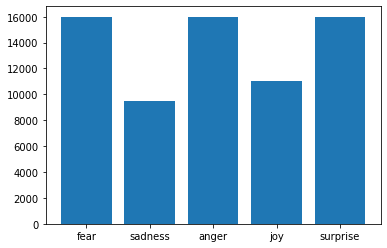

In [34]:
counter = Counter(y_train)
for k,v in counter.items():
	per = v / len(y_train) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()